In [1]:
%load_ext autoreload
%autoreload 2

In [168]:
import xarray as xr
import esm2m.config_perturbations as cp
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
import numpy as np
from scipy.optimize import curve_fit
import cftime
import pandas as pd

In [3]:
mpl.rcParams['font.size'] = 20

In [5]:
rootdir = '/work/gam/projects/bio-pump-timescales/data/esm2m/processed/global_integrals/'
override = False
rootdir = cp.add_override_suffix(rootdir,override)
localdir = 'bling'
variable = '*'

experiments = ['','_gat','_zero','_double']
dd = {}
for e in experiments:
    path = rootdir+localdir+e+'/esm2m_'+variable+e+'.nc'
    dd[e] = xr.open_mfdataset(path)

In [6]:
# Calculate anomaly
ddanom = cp.calc_anom(dd)

In [105]:
def plot_ts(ddanom, variables, experiments=['double','zero'], variables_cumsum = None, save=False):
    '''Time-series plot of [variables]. Specify list of variables that you want to
    plot as cumulative sum in [variables_cumsum]. One experiment plotted per row.'''
    # Assign colors
    tableau = ['blue','orange','green','red','purple',
           'brown','pink','gray','olive','cyan']
    colors = {}
    for j,variable in enumerate(variables):
        colors[variable] = 'tab:'+tableau[j]
    
    ne = len(experiments)
    fig,axarr = plt.subplots(figsize=(16,8),nrows=2)
    tkw = dict(size=6, width=1.5)
    for i,e in enumerate(experiments):
        ds = ddanom[e]
        ax = axarr.flat[i]
        for j,variable in enumerate(variables):
            if j==0:
                axnow = axarr.flat[i]
                axnow.plot(ds['time'],xr.zeros_like(ds['time']),'k--')
            else:
                axnow = axarr.flat[i].twinx()
                offsetax = 1+(j-1)/10
                axnow.spines.right.set_position(("axes",offsetax))
                
            if (variables_cumsum is not None):
                if (variable in variables_cumsum):
                    ts = ds[variable].cumsum('time')
                    linestyle = '--'
                else:
                    ts = ds[variable]
                    linestyle = '-'
            else:
                ts = ds[variable]
                
            p, = axnow.plot(ds['time'],ts,
                            color=colors[variable],
                            linestyle=linestyle,
                            linewidth=4)
            # y-axis origin to same point for all variables
            yabs_max = abs(max(axnow.get_ylim(),key=abs))
            axnow.set_ylim(ymin=-yabs_max, ymax=yabs_max)
            axnow.set_ylabel(variable)
            axnow.yaxis.label.set_color(p.get_color())
            axnow.tick_params(axis='y', colors=p.get_color(), **tkw)
            axnow.autoscale(enable=True,axis='x',tight=True)
            if e == 'zero':
                axnow.invert_yaxis()
        ax.set_title(e)
    fig.tight_layout()

    if save:
        savekwargs = {'transparent':True,'dpi':300}
        savename = ''
        for variable in variables:
            if (variables_cumsum is not None):
                if (variable in variables_cumsum):
                    savename+='cs-'+variable+'.'
                else:
                    savename+=variable+'.'
            else:
                savename+=variable+'.'
        fig.savefig('../../figures/ts_'+savename+'png',**savekwargs)
    
    return fig,axarr


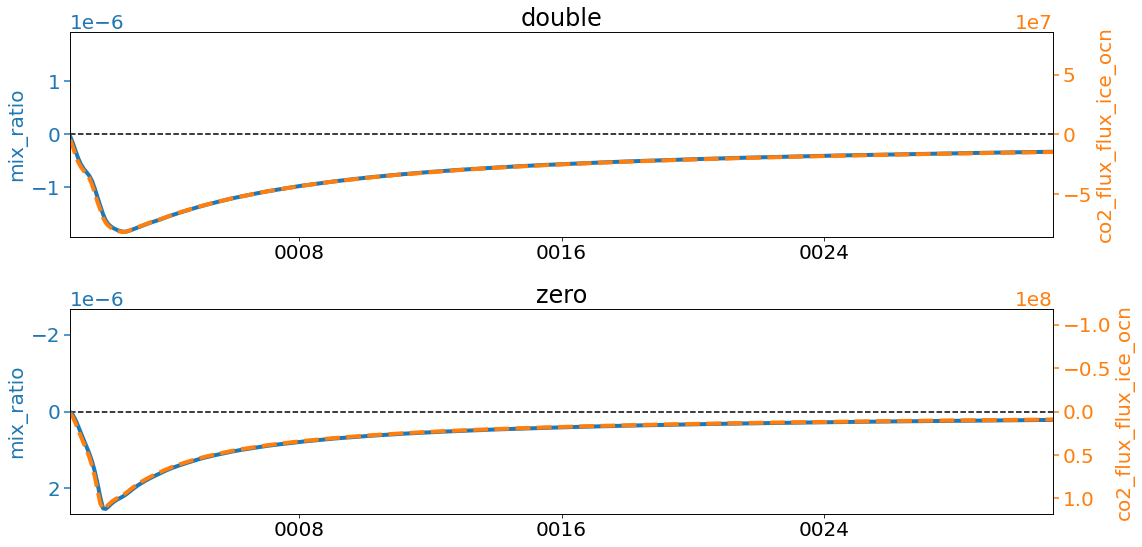

In [107]:
variables = ['mix_ratio','co2_flux_flux_ice_ocn']
save = True
experiments = ['double','zero']
variables_cumsum = ['co2_flux_flux_ice_ocn']
fig,axarr = plot_ts(ddanom,variables,experiments,variables_cumsum=variables_cumsum,save=save)

### Add curve fits

In [108]:
def power_law(x, a, b):
    return a*np.power(x, b)

Text(0018-07-16 12:00:00, <xarray.DataArray 'mix_ratio' ()>
dask.array<nanmax-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>, 'y = 0.00023*t^{-0.73}')

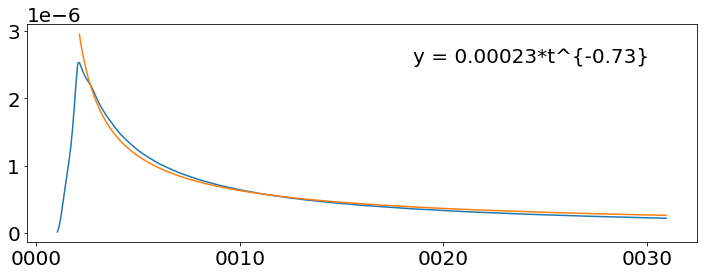

In [110]:
plt.rcParams['text.usetex'] = False
e = 'zero'

fig,ax = plt.subplots(figsize=(12,4))

y = ddanom[e]['mix_ratio']
ymax = y.max()
ymaxind = y.argmax()
ynow = y

yfit = ynow[int(ymaxind):]

time = ddanom[e]['time']
t = np.arange(len(time))*30

tfit = t[int(ymaxind):]
timefit = time[int(ymaxind):]

popt, pcov = curve_fit(f=power_law,
                      xdata=tfit,
                      ydata=yfit,
                      p0=[0, 0],
                      bounds=(-np.inf, np.inf))

fit = power_law(tfit, *popt)

ax.plot(time,ynow)
ax.plot(timefit,fit)
ax.text(time[-150].values,ymax,
        'y = '+str(round(popt[0],5))+'*t^{'+str(round(popt[1],2))+'}')

0006-04-16 00:00:00
0003-11-16 00:00:00


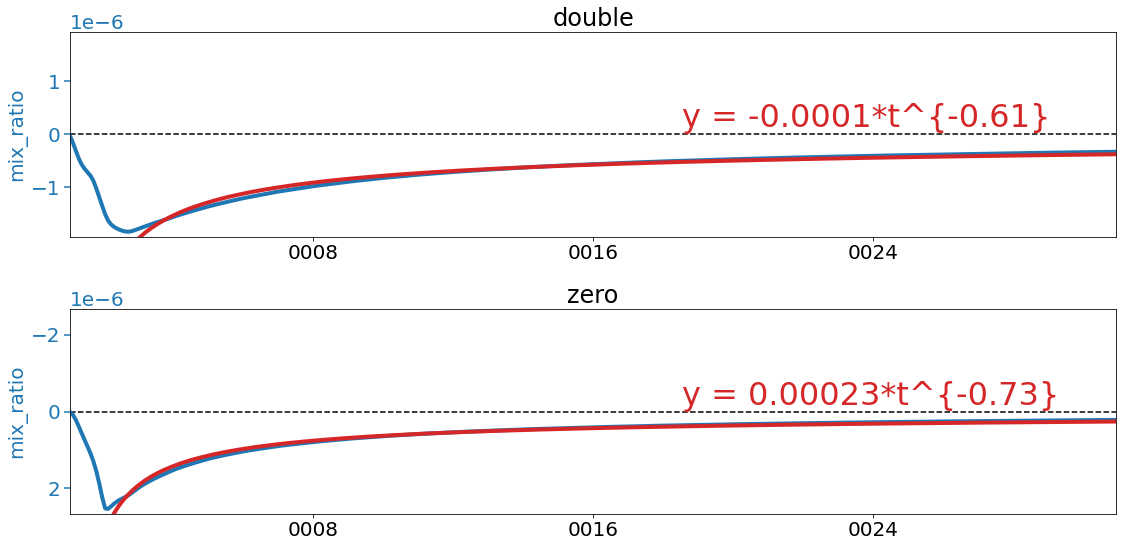

In [189]:
variables = ['mix_ratio']
save = False
experiments = ['double','zero']
variables_cumsum = ['co2_flux_flux_ice_ocn']
fig,axarr = plot_ts(ddanom,variables,experiments,variables_cumsum=variables_cumsum,save=save)

variables_fit = 'mix_ratio'

for i,e in enumerate(experiments):
    y = ddanom[e][variables_fit]
    if e=='zero':
        ym = y.max()
        ymi = y.argmax()
        yfit = y[int(ymi):]
    elif e=='double':
        ym = y.min()
        ymi = y.argmin()
        yfit = y[int(ymi):]

    time = ddanom[e]['time']
    t = np.arange(len(time))*30
    
    tfit = t[int(ymi):]
    timefit = time[int(ymi):]

    popt, pcov = curve_fit(f=power_law,
                          xdata=tfit,
                          ydata=yfit,
                          p0=[0, 0],
                          bounds=(-np.inf, np.inf))

    fit = power_law(tfit, *popt)
    thalf = np.exp(np.log(0.5*tfit[0]**popt[1])/popt[1])/30
    time_thalf = time[int(round(thalf))]
    print(time_thalf.values)
    
    axnow = axarr.flat[i]
    axnow.plot(timefit,fit,color='tab:red',linewidth=4)
    axnow.text(time[-150].values,0,
            'y = '+str(round(popt[0],5))+'*t^{'+str(round(popt[1],2))+'}',
              fontsize=32,verticalalignment='bottom',
              color='tab:red')
    
fig.savefig('../../figures/ts_mix_ratio_fit.png',**{'transparent':True,'dpi':300})

In [190]:
popt

array([ 2.31114824e-04, -7.30943057e-01])

In [186]:
cftime.datetime(6,4,16)

cftime.datetime(6, 4, 16, 0, 0, 0, 0, calendar='gregorian', has_year_zero=False)